# Decoding Strategies

## 학습 목표
1. 자연어처리 모델의 디코딩 전략들을 살펴본다.

**Context**
1. Greedy Search 구현하기
2. Beam Search로 추론하기
3. 그 외에 디코딩 전략들 (feat. sampling)

## 0. 필요한 패키지 및 라이브러리 import 하기

In [ ]:
!pip install transformers

In [ ]:
import torch

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

## 1. Greedy Search 구현하기

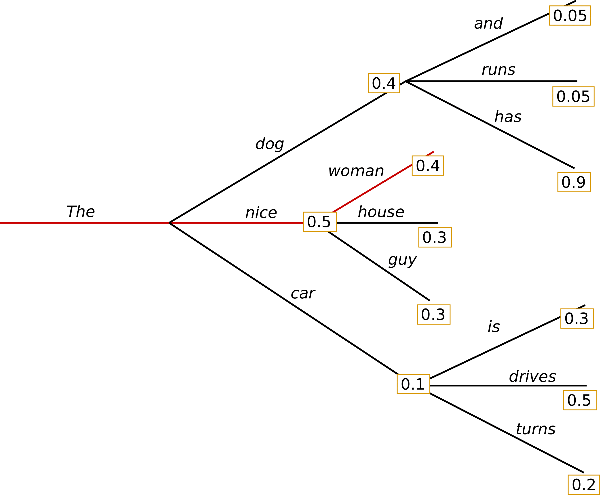

```
💡 Greedy search 란❓

언어 모델이 텍스트를 생성할 때 가장 기초적인 전략으로,
현재 단어를 조건으로 주었을 때 다음 단어로 가장 확률이 높은 단어를 채택하는 방식이다.

위의 그림에서 "The"로 문장을 시작했을 때,
가장 확률이 높은 "nice" (0.5), 그 다음 "woman" (0.4)를 채택하여 "The nice woman..."을 생성한다. (확률 0.5 x 0.4 = 0.2)

하지만 이러한 접근의 치명적인 단점은 확률이 높은 단어가 앞의 확률이 낮은 단어에 가려질 수 있다는 점이다. 

여기서 "has"는 "dog" 뒤에 0.9라는 높은 조건부 확률을 가지고 있다.
"The dog has"는 확률이 0.36임으로 "The nice woman"보다 높지만,
greedy search의 특성상 이런 부분을 놓치게 된다.

✨ Greedy search를 구현하면서 깊게 살펴보도록 한다.
```
참고: https://huggingface.co/blog/how-to-generate

> 여러 디코딩 전략들을 살펴보기 위해, 사전 학습된 인코더-디코더 구조의 T5 모델을 불러온다.
>
> Text-to-Text Transfer Transformer (T5) 모델에 대한 자세한 내용은 해당 논문이나 블로그 등을 참고하면 좋을 것 같다.

참고: https://arxiv.org/abs/1910.10683

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-base")    # ~ForSeq2SeqLM 클래스는 디코더 위에 추가로 LM 층이 있다.

In [ ]:
def greedy_search(sentence, max_length=20):
    batch_size = 1

    # 텍스트를 토큰 인덱스로 변환
    encoder_input_ids = tokenizer(sentence, return_tensors="pt").input_ids
    
    # 디코더에 첫 입력은 decoder_start_token_id가 들어감 (T5에서는 pad_token_id인 0이 사용된다.)
    input_ids = torch.ones((batch_size, 1), dtype=torch.long) * model.generation_config.decoder_start_token_id

    model_kwargs = {}
    model_kwargs["encoder_outputs"] = model.get_encoder()(encoder_input_ids)    # 인코더의 hidden state 저장
    model_kwargs["input_ids"] = None                                            # 생성할 때는 input_ids를 None으로 지정
    model_kwargs["decoder_input_ids"] = input_ids
    model_kwargs["return_dict"] = True
    model_kwargs["past"] = None

    cur_len = input_ids.shape[-1]
    model_inputs = {'input_ids': None, 'encoder_outputs': model_kwargs['encoder_outputs']}

    while True:
        model_inputs["decoder_input_ids"] = input_ids[:,-1].unsqueeze(-1)   # current seen token만 디코더에 올려줌
        model_inputs["past_key_values"] = model_kwargs["past"]              # 이전 토큰의 decoder hidden states를 저장

        outputs = model(**model_inputs)
        next_token_logits = outputs.logits[:, -1, :]                        # (batch_size, seq_len, vocab_size) -> (batch_size, vocab_size) 
        next_tokens = torch.argmax(next_token_logits, dim=-1)               # greedy search는 가장 확률이 높은 단어(i.e., argmax)로 예측

        input_ids = torch.cat([input_ids, next_tokens[:, None]], dim=-1)    # 채택된 토큰은 최종 output에 concat
        model_kwargs["past"] = outputs.past_key_values

        cur_len = cur_len + 1

        # max_length를 도달했거나 EOS 토큰을 생성할 시 생성을 멈춤
        if cur_len == max_length or next_tokens == model.generation_config.eos_token_id:
            break

    return tokenizer.batch_decode(input_ids, skip_special_tokens=True)

> T5 모델은 프롬프트(prompt)로 "translate X to Y"를 주면 X 언어를 Y 언어로 번역한다.
>
> 하지만 번역할 수 있는 언어는 한정적이다. 번역에 특화된 모델은 multilingual T5 (mT5)를 확인해보는 것을 추천한다.

In [ ]:
encoder_input_str = "translate English to French: When does the birthday party start?"
greedy_search(encoder_input_str)

["Quand commence la fête d'anniversaire?"]

In [ ]:
encoder_input_str = "translate English to German: When does the birthday party start?"
greedy_search(encoder_input_str)

['Wann beginnt die Geburtstagsfeier?']

In [ ]:
encoder_input_str = "translate English to Romanian: When does the birthday party start?"
greedy_search(encoder_input_str)

['Când începe sărbătoarea de naştere?']

> 한국어로는 학습되지 않았기 때문에 번역이 되지 않는다.

In [ ]:
encoder_input_str = "translate English to Korean: When does the birthday party start?"
greedy_search(encoder_input_str)

['Wann beginnt die Geburtstagsfeier?']

>💡 Huggingface 모델 사용 시 `generate()` 함수를 통해 greedy search를 손쉽게 사용할 수 있다.

In [ ]:
encoder_input_str = "translate English to French: When does the birthday party start?"
inputs = tokenizer(encoder_input_str, return_tensors="pt")

tokenizer.batch_decode(model.generate(**inputs), skip_special_tokens=True)

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


["Quand commence la fête d'anniversaire?"]

In [ ]:
encoder_input_str = "translate English to French: Beam search is an algorithm used in many NLP and speech recognition models as a final decision making " + \
                    "layer to choose the best output given target variables like maximum probability or next output character. First used for speech recognition " + \
                    "in 1976, beam search is used often in models that have encoders and decoders with LSTM or Gated Recurrent Unit modules built in. " + \
                    "To understand where this algorithm is used a little more let's take a look at how NLP models generate output, to see where Beam search comes into play."
inputs = tokenizer(encoder_input_str, return_tensors="pt")

tokenizer.batch_decode(model.generate(**inputs, max_length=200), skip_special_tokens=True)

["La recherche par faisceau est un algorithme utilisé dans de nombreux modèles de LNP et de reconnaissance de la parole comme couche de décision finale pour choisir la meilleure sortie en fonction de variables cibles comme la probabilité maximale ou le caractère de sortie suivant. Utilisée pour la première fois en 1976, la recherche par faisceau est souvent utilisée dans des modèles qui ont des encodeurs et des décodeurs avec des modules LSTM ou des modules d'unités récurrentes à"]

> T5 모델은 translation 뿐만 아니라 summarization 태스크도 수행한다.
>
> 보시다시피 greedy search는 멀리 보지 못하고 당장 확률이 높은 단어만 채택하기 때문에 언어가 반복되는 것을 확인할 수 있다.
>
> 이런 degeneration을 완화하고자 beam search 등 다양한 디코딩 전략들이 제안되었다.

In [ ]:
sentence = "summarize: Paris is the capital and most populous city of France, with an estimated population of 2,175,601 residents as of 2018," + \
           " in an area of more than 105 square kilometres (41 square miles). The City of Paris is the centre and seat of government of the region "+ \
           "and province of Île-de-France, or Paris Region, which has an estimated population of 12,174,880, or about 18 percent of the population of France as of 2017."

inputs = tokenizer(sentence, return_tensors="pt")
tokenizer.batch_decode(model.generate(**inputs, max_length=200), skip_special_tokens=True)

['the city of Paris is the centre and seat of government of the region and province of Île-de-France, or Paris Region. it has an estimated population of 2,175,601 residents as of 2018, in an area of more than 105 square kilometres (41 square miles) the city is the capital and most populous city of France, with an estimated population of 2,175,601.']

## 2. Beam Search로 추론하기

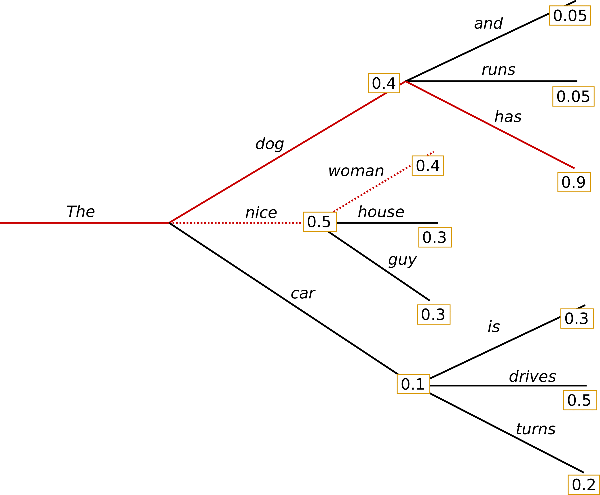

```
💡 Beam search 란❓

Greedy search처럼 당장에 제일 확률이 높은 단어로 다음 단어를 예측하는 것이 아니라,
여러 경우의 수를 고려하는 방법이다.

제일 정확도가 높은 방법은 모든 경우의 수를 보는 것(Exhaustive search)이 겠지만,
vocabulary 개수가 보통 만 개 단위이기 때문에 너무나 많은 연산을 요구하게 된다.

Beam search는 greedy와 exhaustive search의 trade-off를 고려한다.
유망하다고 판단되는 빔 K개를 골라서 K 경우의 수만 보게 된다.

시간복잡도 면에서는 greedy보다 느리지만 좀 더 정확한 생성을 할 수 있다.
빔 개수 K를 몇으로 설정하냐에 따라 결과와 수행시간이 달라지기 때문에 적절한 K를 찾는 것이 필요하다.

Greedy search는 K가 1일 때를 가리킨다.
```

참고: https://huggingface.co/blog/how-to-generate

In [ ]:
encoder_input_str = "translate English to French: When does the birthday party start?"
inputs = tokenizer(encoder_input_str, return_tensors="pt")

tokenizer.batch_decode(model.generate(**inputs, num_beams=4), skip_special_tokens=True)

["Quand commence la fête d'anniversaire?"]

In [ ]:
encoder_input_str = "translate English to French: Beam search is an algorithm used in many NLP and speech recognition models as a final decision making " + \
                    "layer to choose the best output given target variables like maximum probability or next output character. First used for speech recognition " + \
                    "in 1976, beam search is used often in models that have encoders and decoders with LSTM or Gated Recurrent Unit modules built in. " + \
                    "To understand where this algorithm is used a little more let's take a look at how NLP models generate output, to see where Beam search comes into play."
inputs = tokenizer(encoder_input_str, return_tensors="pt")

tokenizer.batch_decode(model.generate(**inputs, num_beams=4, max_length=200), skip_special_tokens=True)

["La recherche par faisceau est un algorithme utilisé dans de nombreux modèles de LNP et de reconnaissance de la parole comme couche de décision finale pour choisir la meilleure sortie en fonction de variables cibles comme la probabilité maximale ou le caractère de sortie suivant. Utilisée pour la première fois en 1976 pour la reconnaissance de la parole, la recherche par faisceau est souvent utilisée dans des modèles qui ont des encodeurs et des décodeurs équipés de modules LSTM ou d'unités ré"]

> Beam search로 summarization을 수행했을 때, 반복되는 구절들이 삭제된 것을 확인할 수 있다.

In [ ]:
sentence = "summarize: Paris is the capital and most populous city of France, with an estimated population of 2,175,601 residents as of 2018," + \
           " in an area of more than 105 square kilometres (41 square miles). The City of Paris is the centre and seat of government of the region "+ \
           "and province of Île-de-France, or Paris Region, which has an estimated population of 12,174,880, or about 18 percent of the population of France as of 2017."

inputs = tokenizer(sentence, return_tensors="pt")
tokenizer.batch_decode(model.generate(**inputs, num_beams=4, max_length=200), skip_special_tokens=True)

['the capital and most populous city of France, with an estimated population of 2,175,601 residents as of 2018, in an area of more than 105 square kilometres (41 square miles) the city is the centre and seat of government of the region and province of Île-de-France, or Paris Region, which has an estimated population of 12,174,880.']

## 3. 그 외의 디코딩 전략들 (feat. sampling)

### 3-1. Top-K Sampling

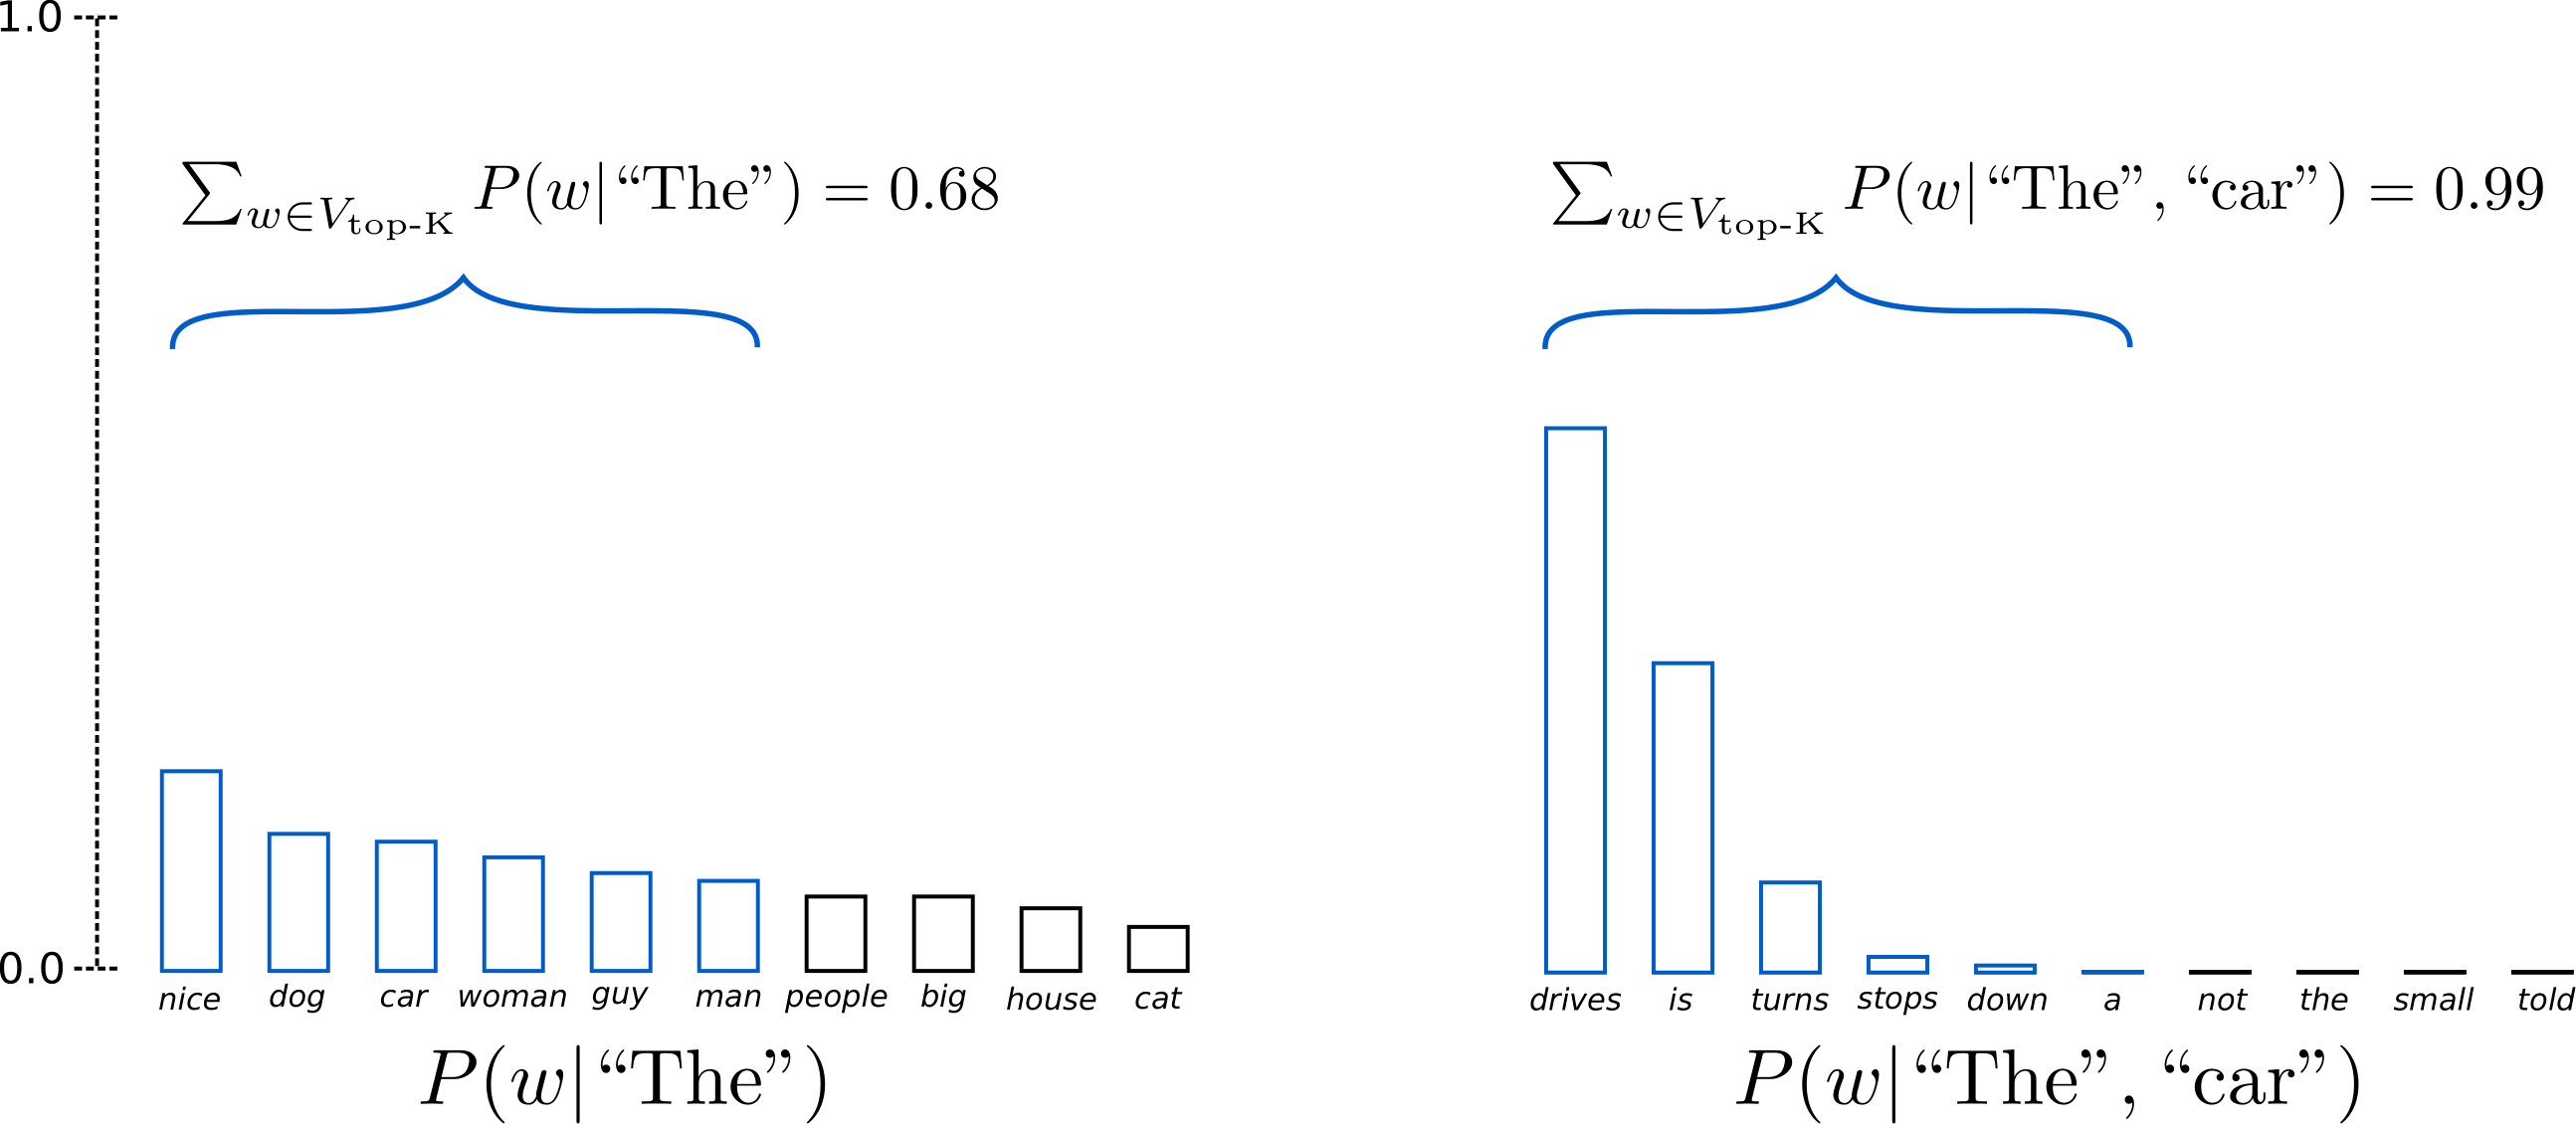

```
💡 Top-K sampling은 K개의 most likely next words에서 샘플링을 하여 생성하는 방식이다 GPT-2가 이 방식을 채택하였다.
```
참고: [Hierarchical Neural Story Generation (Fan et al., 2018)](https://arxiv.org/pdf/1805.04833.pdf)

In [ ]:
encoder_input_str = "translate English to French: When does the birthday party start?"
inputs = tokenizer(encoder_input_str, return_tensors="pt")

tokenizer.batch_decode(model.generate(**inputs, do_sample=True, top_k=50), skip_special_tokens=True)

["Quand commence la fête d'anniversaire?"]

In [ ]:
encoder_input_str = "translate English to French: Beam search is an algorithm used in many NLP and speech recognition models as a final decision making " + \
                    "layer to choose the best output given target variables like maximum probability or next output character. First used for speech recognition " + \
                    "in 1976, beam search is used often in models that have encoders and decoders with LSTM or Gated Recurrent Unit modules built in. " + \
                    "To understand where this algorithm is used a little more let's take a look at how NLP models generate output, to see where Beam search comes into play."
inputs = tokenizer(encoder_input_str, return_tensors="pt")

tokenizer.batch_decode(model.generate(**inputs, do_sample=True, top_k=50, max_length=200), skip_special_tokens=True)

["B.Support: Un type de surveillance par un opération, qui consiste à répertorier et produire le signal initial pour que les échantillons de contenu de taquettes soient référencés dans un système au sol. Avec Internet - le Web, la plupart des services de recherche s'élèvent sur Internet."]

In [ ]:
sentence = "summarize: Paris is the capital and most populous city of France, with an estimated population of 2,175,601 residents as of 2018," + \
           " in an area of more than 105 square kilometres (41 square miles). The City of Paris is the centre and seat of government of the region "+ \
           "and province of Île-de-France, or Paris Region, which has an estimated population of 12,174,880, or about 18 percent of the population of France as of 2017."

inputs = tokenizer(sentence, return_tensors="pt")
tokenizer.batch_decode(model.generate(**inputs, do_sample=True, top_k=50, max_length=200), skip_special_tokens=True)

['capital and most populous city of France and an estimated 2,175,601 residents as of 2018. city of Paris is a centre and seat of government of Île-de-France.']

###3-2. Top-p (Nucleus) Sampling

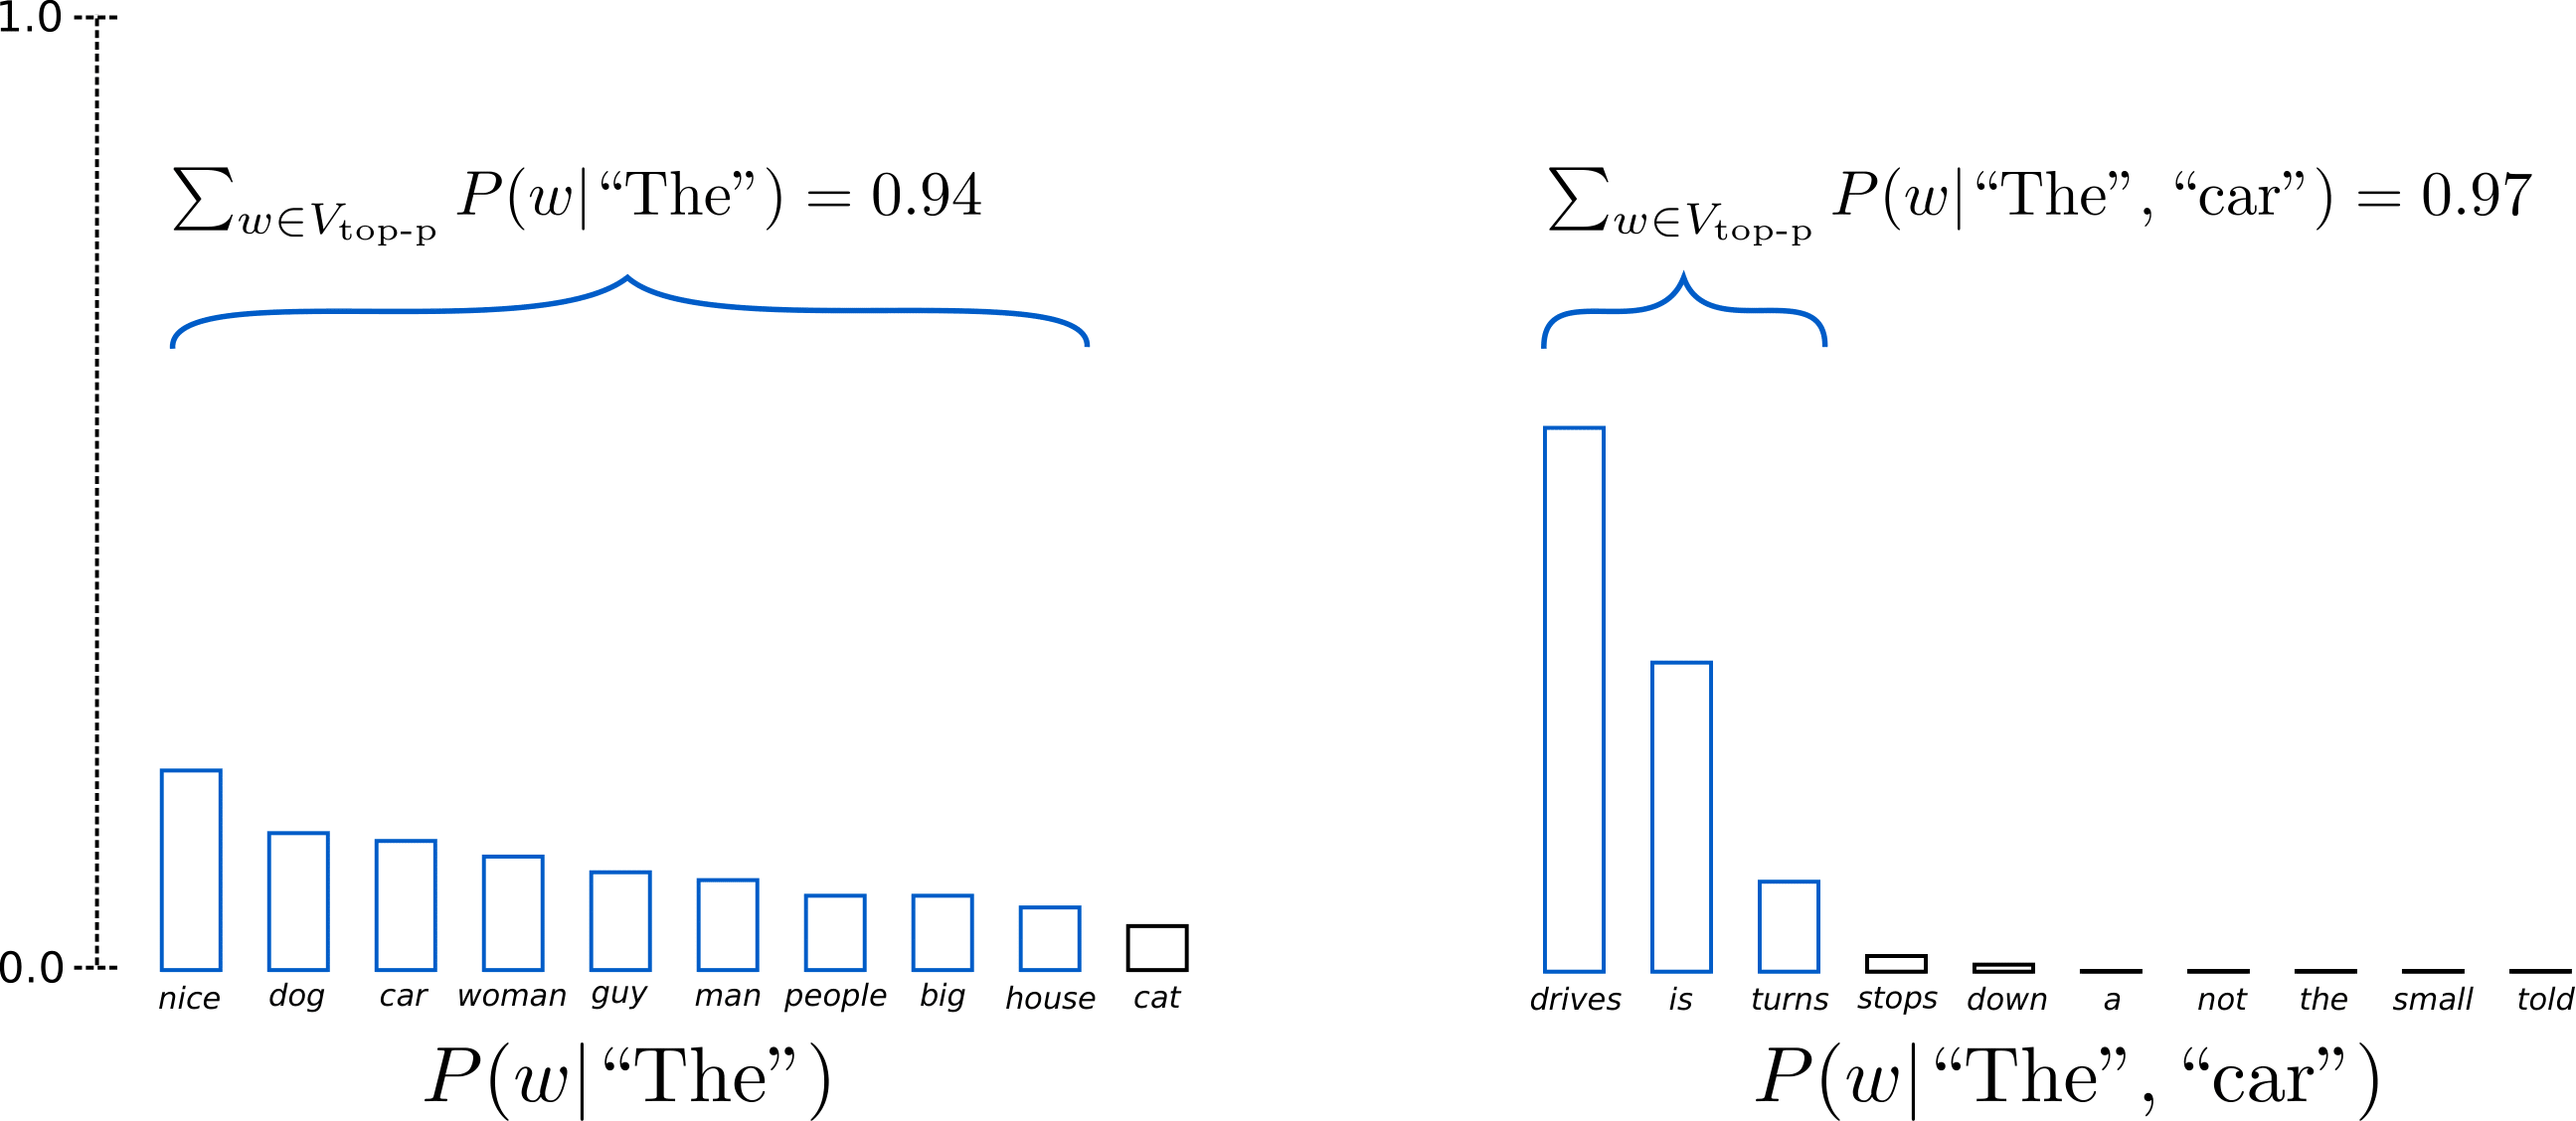

```
💡 Top-P sampling은 top P%의 probability mass에서 샘플링을 하여 생성하는 방식이다.
Top-K sampling의 고정값 K를 좀 더 유연하게 만들어 준다.
```
참고: [The Curious Case of Neural Text Degeneration (Choi et al., 2018)](https://arxiv.org/pdf/1904.09751.pdf)

In [ ]:
encoder_input_str = "translate English to French: When does the birthday party start?"
inputs = tokenizer(encoder_input_str, return_tensors="pt")

tokenizer.batch_decode(model.generate(**inputs, do_sample=True, top_p=0.92, top_k=0), skip_special_tokens=True)

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[' quel moment la fête d’anniversaire débute-t-elle?']

In [ ]:
encoder_input_str = "translate English to French: Beam search is an algorithm used in many NLP and speech recognition models as a final decision making " + \
                    "layer to choose the best output given target variables like maximum probability or next output character. First used for speech recognition " + \
                    "in 1976, beam search is used often in models that have encoders and decoders with LSTM or Gated Recurrent Unit modules built in. " + \
                    "To understand where this algorithm is used a little more let's take a look at how NLP models generate output, to see where Beam search comes into play."
inputs = tokenizer(encoder_input_str, return_tensors="pt")

tokenizer.batch_decode(model.generate(**inputs, do_sample=True, top_p=0.92, top_k=0, max_length=200), skip_special_tokens=True)

["La recherche par faisceau est un algorithme utilisé dans de nombreux modèles de la NLP et de la reconnaissance de la parole, qui sert de couche finale de décision en vue de choisir la meilleure sortie donnée aux variables cibles, comme la probabilité maximale ou le caractère d'entrée suivant. Utilisé pour la première fois en 1976, la recherche par faisceau est souvent utilisée dans des modèles ayant des encodeurs et des décodeurs associés aux modules LSMC ou Gate"]

In [ ]:
sentence = "summarize: Paris is the capital and most populous city of France, with an estimated population of 2,175,601 residents as of 2018," + \
           " in an area of more than 105 square kilometres (41 square miles). The City of Paris is the centre and seat of government of the region "+ \
           "and province of Île-de-France, or Paris Region, which has an estimated population of 12,174,880, or about 18 percent of the population of France as of 2017."

inputs = tokenizer(sentence, return_tensors="pt")
tokenizer.batch_decode(model.generate(**inputs, do_sample=True, top_p=0.92, top_k=0, max_length=200), skip_special_tokens=True)

['Paris is capital and most populous city of France, with estimated population of 2,175,601 residents as of 2018. city centre and seat of government of Île-de-France which has an estimated population of 12,174,880.']